**Welcome to this Notebook!**

UCLouvain - EPL - made by Justin Weeamels & Baptiste Sambon - 2023

*In this notebook, be ready to dsicover an implementation and simulation of a downlink Non-Otrhogonal Multiple Access (NOMA) communication scheme.*

*As a first step, let's import some useful packages.* **As said in the README, run this file twice!**

In [3]:
import numpy as np

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna
import tensorflow as tf

from utils import *                # Several useful functions are defined in the utils.py module and are used hereafter in the simulation
import matplotlib.pyplot as plt
from termcolor import colored
from scipy.special import erfc

*The parameters defining the simulations are stored in a dictionary called "tx_params". Because we are in a perfect CSI case, these informations will be sent from the BS to the UE as a pilot before any communication.*

In [4]:
tx_params = {
    "nUsers" : 3,                      # The number of users. 
    "powerAllocation" : np.zeros(3),   # Initialisation of an array representing the power allocation for each user. 
    "nCode" : 120,                     # The number of bits representing the message to send after coding. 
    "kCode" : 60,                      # The number of bits representing the message to send.
    "codingRate": 1/2,                 # The coding rate of the error correcting code. 
}

*Several useful modules are imported from the sionna library to perform the simulation.*

In [5]:
nmodbits = 2                                                                                        # Number of bits per symbol 
binary_source = sionna.utils.BinarySource()                                                         # Creation of a binary source (to generate the bits to send)            
constellation = sionna.mapping.Constellation("qam", nmodbits)                                       # Creation of a constellation 
mapper = sionna.mapping.Mapper(constellation=constellation)                                         # Creation of a mapper (to map the bits to symbols)                         
demapper = sionna.mapping.Demapper("app","qam", nmodbits, hard_out=True,  dtype=tf.complex128)      # Creation of a demapper (to demap the symbols to bits)

*As a first curve, the BER-SNR curve is plotted and obtained based on results from the simulations (without considering the inter-cell-interference yet).*

In [6]:
# Some parameters used to loop on the different SNR values and evaluate the BER.
ebn0 = np.arange(0, 21, 1) #dB
snr_db = ebn0 + 10*np.log10(tx_params["codingRate"]) + 10*np.log10(nmodbits) #dB
nb_seq =300
alpha = 0

# Initialization of the BER arrays to store the BER values for the different SNR values.
BER_coded = np.zeros(len(ebn0))
BER_uncoded = np.zeros(len(ebn0))

# Constrcution of the convolutional correcting code
gn = np.array([1, 1])
gd = np.array([1, 1, 1])
R1,R0,out_R1,out_R0 = poly2trellis(gn,gd)
d = 1
out_R1_tf = tf.convert_to_tensor(out_R1)
out_R0_tf = tf.convert_to_tensor(out_R0)
symb_R1 = mapper(out_R1_tf).numpy()
symb_R0 = mapper(out_R0_tf).numpy()

#Loop on the different SNR values
for ii in range(len(snr_db)) :

  # Initialization of the BER arrays to store the BER values for the different sequences.
  BER_coded_ii = np.zeros(nb_seq)
  BER_uncoded_ii = np.zeros(nb_seq)

  # Computation of the noise variance from the SNR value.
  var_noise = 1/(10**(0.1*snr_db[ii]))
  len_b = tx_params["kCode"]

  # Loop on the different sequences
  for jj in range(nb_seq) :

    # NOMA Power allocation
    Ptot_db = 10 # total power allocation in dB
    Ptot = 10**(0.1*Ptot_db)
    # Allocation of the power to the different users
    tx_params["powerAllocation"] =  get_power_allocation(tx_params, Ptot, var_noise)

    # Generation of the data to send
    data = np.zeros((tx_params["nUsers"], tx_params["nCode"])) # initialize the data to send
    b = binary_source([tx_params["nUsers"], tx_params["kCode"]]) # bits to send for each user
    b_array = b.numpy()

    # Encode the data to send for each user
    c_array = np.zeros((tx_params["nUsers"], 2*len(b_array[0])))
    for idx_user in range(tx_params["nUsers"]):
      (u_s,u_c) = conv_encoder(b_array[idx_user],R1,R0,out_R1,out_R0,len_b)
      c_array[idx_user] = np.reshape(np.transpose([u_s,u_c]),(2*len(u_s),))
    c = tf.convert_to_tensor(c_array)

    # Mapping the bits
    x = mapper(c)
    data = x.numpy()

    # Use of NOMA principle to separate the users in power
    data_out = NOMA(data, tx_params)
    
    # Channel and noise
    h = Rayleigh_canal(alpha, len(data_out))
    n = (1j*np.random.normal(scale=np.sqrt(var_noise/2), size=data_out.shape)+np.random.normal(scale=np.sqrt(var_noise/2),  size=data_out.shape))
    y_canal = h*data_out+n

    # Reception 
    y_received = MyMMSE(data_out, h, var_noise, y_canal) # MMSE equalisation
    
    # Initialization of the arrays to store the decoded data
    y_decoded = np.zeros((tx_params["nUsers"], tx_params["kCode"]))
    y_demapped = np.zeros((tx_params["nUsers"], tx_params["nCode"])) # nCode noramlement (à changer après)

    # SIC 
    for idx_user in range(tx_params["nUsers"]):
      
      # Demapping
      y = demapper([tf.convert_to_tensor(y_received), var_noise])
      y_demapped[idx_user, :] = y.numpy()

      # Decoding
      y_user = viterbi_decoder(R1,R0,symb_R1, symb_R0,len_b, y_received)
      y_decoded[idx_user, :] = y_user

      # Re-encode the decoded data to retrieve the message of the next user
      (u_s,u_c) = conv_encoder(y_user,R1,R0,out_R1,out_R0,len_b)
      y_user_encoded = np.reshape(np.transpose([u_s,u_c]),(2*len(u_s),))
      y_user_encoded = tf.convert_to_tensor(y_user_encoded.reshape((1, len(y_user_encoded))))
      
      # Remove the decoded data from the received data
      y_received = y_received - mapper(y_user_encoded).numpy()[0]*np.sqrt(tx_params["powerAllocation"][idx_user])

    # Compute the BER for the different users
    y_demapped_tf = tf.convert_to_tensor(y_demapped)
    y_decoded_tf = tf.convert_to_tensor(y_decoded)
    c_hat = tf.cast(tf.less(0.0, y_demapped_tf), tf.double)
    b_hat = tf.cast(tf.less(0.0, y_decoded_tf), tf.float32)
    ber_uncoded = sionna.utils.metrics.compute_ber(c, c_hat)
    ber_coded = sionna.utils.metrics.compute_ber(b, b_hat)

    # Calculate the BER for the different users
    BER_coded_ii[jj] = ber_coded.numpy()
    BER_uncoded_ii[jj] = ber_uncoded.numpy()

  # Calculate the BER for the different SNR values
  BER_coded[ii] = np.mean(BER_coded_ii)
  BER_uncoded[ii] = np.mean(BER_uncoded_ii)

  print("Eb/N0 = " + str(ebn0[ii]) +  "dB, BER uncoded = " +  str(BER_uncoded[ii]) + ", BER coded = " + str(BER_coded[ii]))
  

Eb/N0 = 0dB, BER uncoded = 0.21786111111111112, BER coded = 0.1821111111111111
Eb/N0 = 1dB, BER uncoded = 0.18977777777777777, BER coded = 0.14683333333333332
Eb/N0 = 2dB, BER uncoded = 0.1593425925925926, BER coded = 0.11333333333333333
Eb/N0 = 3dB, BER uncoded = 0.1368703703703704, BER coded = 0.09427777777777777
Eb/N0 = 4dB, BER uncoded = 0.10811111111111113, BER coded = 0.06907407407407407
Eb/N0 = 5dB, BER uncoded = 0.09030555555555556, BER coded = 0.059129629629629636
Eb/N0 = 6dB, BER uncoded = 0.07062962962962963, BER coded = 0.04387037037037037
Eb/N0 = 7dB, BER uncoded = 0.05606481481481481, BER coded = 0.030425925925925922
Eb/N0 = 8dB, BER uncoded = 0.045361111111111116, BER coded = 0.027129629629629632
Eb/N0 = 9dB, BER uncoded = 0.03886111111111111, BER coded = 0.023499999999999997
Eb/N0 = 10dB, BER uncoded = 0.033527777777777774, BER coded = 0.019629629629629632
Eb/N0 = 11dB, BER uncoded = 0.02884259259259259, BER coded = 0.01624074074074074
Eb/N0 = 12dB, BER uncoded = 0.0251

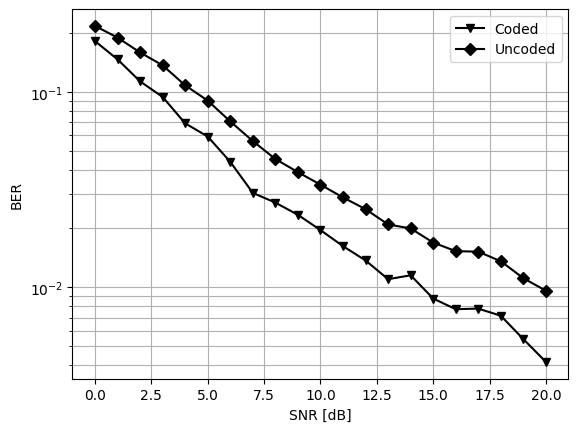

In [7]:
# Plot the results obtained from the simulation

plt.figure()
plt.semilogy(snr_db, BER_coded, "v-", label="Coded", color="black")
plt.semilogy(snr_db, BER_uncoded, "D-", label="Uncoded", color="black")
plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.xscale("linear")
plt.yscale("log")
plt.grid(which="both")
plt.legend()
plt.show()

*Now, let's do the same thing but with the inter-cell-interference. The BER-SNR curve is plotted and obtained based on results from the simulations (considering the inter-cell-interference).*

In [36]:
# Let's first impotr the pdf of the interferences 

# Load interferences
interrference_ratio = np.load("data/ratio_power_interf.npy")

In [37]:
# Some parameters used to loop on the different SNR values and evaluate the BER.
ebn0 = np.arange(0, 21, 1) #dB
snr_db = ebn0 + 10*np.log10(tx_params["codingRate"]) + 10*np.log10(nmodbits) #dB
nb_seq =300
alpha = 0

# Initialization of the BER arrays to store the BER values for the different SNR values.
BER_coded_interf = np.zeros(len(ebn0))
BER_uncoded_interf = np.zeros(len(ebn0))

# Constrcution of the convolutional correcting code
gn = np.array([1, 1])
gd = np.array([1, 1, 1])
R1,R0,out_R1,out_R0 = poly2trellis(gn,gd)
d = 1
out_R1_tf = tf.convert_to_tensor(out_R1)
out_R0_tf = tf.convert_to_tensor(out_R0)
symb_R1 = mapper(out_R1_tf).numpy()
symb_R0 = mapper(out_R0_tf).numpy()

#Loop on the different SNR values
for ii in range(len(snr_db)) :

  # Initialization of the BER arrays to store the BER values for the different sequences.
  BER_coded_interf_ii = np.zeros(nb_seq)
  BER_uncoded_interf_ii = np.zeros(nb_seq)

  # Computation of the noise variance from the SNR value.
  var_noise = 1/(10**(0.1*snr_db[ii]))
  len_b = tx_params["kCode"]

  # Loop on the different sequences
  for jj in range(nb_seq) :

    # NOMA Power allocation
    Ptot_db = 10 # total power allocation in dB
    Ptot = 10**(0.1*Ptot_db)
    # Allocation of the power to the different users
    tx_params["powerAllocation"] =  get_power_allocation(tx_params, Ptot, var_noise)

    # Generation of the data to send
    data = np.zeros((tx_params["nUsers"], tx_params["nCode"])) # initialize the data to send
    b = binary_source([tx_params["nUsers"], tx_params["kCode"]]) # bits to send for each user
    b_array = b.numpy()

    # Encode the data to send for each user
    c_array = np.zeros((tx_params["nUsers"], 2*len(b_array[0])))
    for idx_user in range(tx_params["nUsers"]):
      (u_s,u_c) = conv_encoder(b_array[idx_user],R1,R0,out_R1,out_R0,len_b)
      c_array[idx_user] = np.reshape(np.transpose([u_s,u_c]),(2*len(u_s),))
    c = tf.convert_to_tensor(c_array)

    # Mapping the bits
    x = mapper(c)
    data = x.numpy()

    # Use of NOMA principle to separate the users in power
    data_out = NOMA(data, tx_params)
    
    # Channel, noise and interference 
    h = Rayleigh_canal(alpha, len(data_out))
    n = (1j*np.random.normal(scale=np.sqrt(var_noise/2), size=data_out.shape)+np.random.normal(scale=np.sqrt(var_noise/2),  size=data_out.shape))
    interference = 1/np.random.choice(interrference_ratio, size=h.shape) # Interference from other cell 
    # Random data of other cell
    possible_values = np.sqrt(2)*np.array([1+1j, -1-1j, 1-1j, -1+1j])
    data_other_cell = np.random.choice(possible_values, size=h.shape)
    # Effect of canal, noise and interference on the useful data
    y_canal = h*data_out+n+interference*data_other_cell

    # Reception 
    y_received = MyMMSE(data_out, h, var_noise, y_canal) # MMSE equalisation
    
    # Initialization of the arrays to store the decoded data
    y_decoded = np.zeros((tx_params["nUsers"], tx_params["kCode"]))
    y_demapped = np.zeros((tx_params["nUsers"], tx_params["nCode"])) # nCode noramlement (à changer après)

    # SIC 
    for idx_user in range(tx_params["nUsers"]):
      
      # Demapping
      y = demapper([tf.convert_to_tensor(y_received), var_noise])
      y_demapped[idx_user, :] = y.numpy()

      # Decoding
      y_user = viterbi_decoder(R1,R0,symb_R1, symb_R0,len_b, y_received)
      y_decoded[idx_user, :] = y_user

      # Re-encode the decoded data to retrieve the message of the next user
      (u_s,u_c) = conv_encoder(y_user,R1,R0,out_R1,out_R0,len_b)
      y_user_encoded = np.reshape(np.transpose([u_s,u_c]),(2*len(u_s),))
      y_user_encoded = tf.convert_to_tensor(y_user_encoded.reshape((1, len(y_user_encoded))))
      
      # Remove the decoded data from the received data
      y_received = y_received - mapper(y_user_encoded).numpy()[0]*np.sqrt(tx_params["powerAllocation"][idx_user])

    # Compute the BER for the different users
    y_demapped_tf = tf.convert_to_tensor(y_demapped)
    y_decoded_tf = tf.convert_to_tensor(y_decoded)
    c_hat = tf.cast(tf.less(0.0, y_demapped_tf), tf.double)
    b_hat = tf.cast(tf.less(0.0, y_decoded_tf), tf.float32)
    ber_uncoded = sionna.utils.metrics.compute_ber(c, c_hat)
    ber_coded = sionna.utils.metrics.compute_ber(b, b_hat)

    # Calculate the BER for the different users
    BER_coded_interf_ii[jj] = ber_coded.numpy()
    BER_uncoded_interf_ii[jj] = ber_uncoded.numpy()

  # Calculate the BER for the different SNR values
  BER_coded_interf[ii] = np.mean(BER_coded_interf_ii)
  BER_uncoded_interf[ii] = np.mean(BER_uncoded_interf_ii)

  print("Eb/N0 = " + str(ebn0[ii]) +  "dB, BER uncoded = " +  str(BER_uncoded_interf[ii]))
  

Eb/N0 = 0dB, BER uncoded = 0.2782407407407408
Eb/N0 = 1dB, BER uncoded = 0.2647222222222222
Eb/N0 = 2dB, BER uncoded = 0.24957407407407406
Eb/N0 = 3dB, BER uncoded = 0.23498148148148146
Eb/N0 = 4dB, BER uncoded = 0.2194814814814815
Eb/N0 = 5dB, BER uncoded = 0.2040740740740741
Eb/N0 = 6dB, BER uncoded = 0.19274074074074074
Eb/N0 = 7dB, BER uncoded = 0.18571296296296297
Eb/N0 = 8dB, BER uncoded = 0.1835
Eb/N0 = 9dB, BER uncoded = 0.17583333333333334
Eb/N0 = 10dB, BER uncoded = 0.1721111111111111
Eb/N0 = 11dB, BER uncoded = 0.17329629629629628
Eb/N0 = 12dB, BER uncoded = 0.16958333333333334
Eb/N0 = 13dB, BER uncoded = 0.17087962962962963
Eb/N0 = 14dB, BER uncoded = 0.16947222222222222
Eb/N0 = 15dB, BER uncoded = 0.17104629629629628
Eb/N0 = 16dB, BER uncoded = 0.16974074074074072
Eb/N0 = 17dB, BER uncoded = 0.17133333333333334
Eb/N0 = 18dB, BER uncoded = 0.17287962962962966
Eb/N0 = 19dB, BER uncoded = 0.17400000000000002
Eb/N0 = 20dB, BER uncoded = 0.1759814814814815


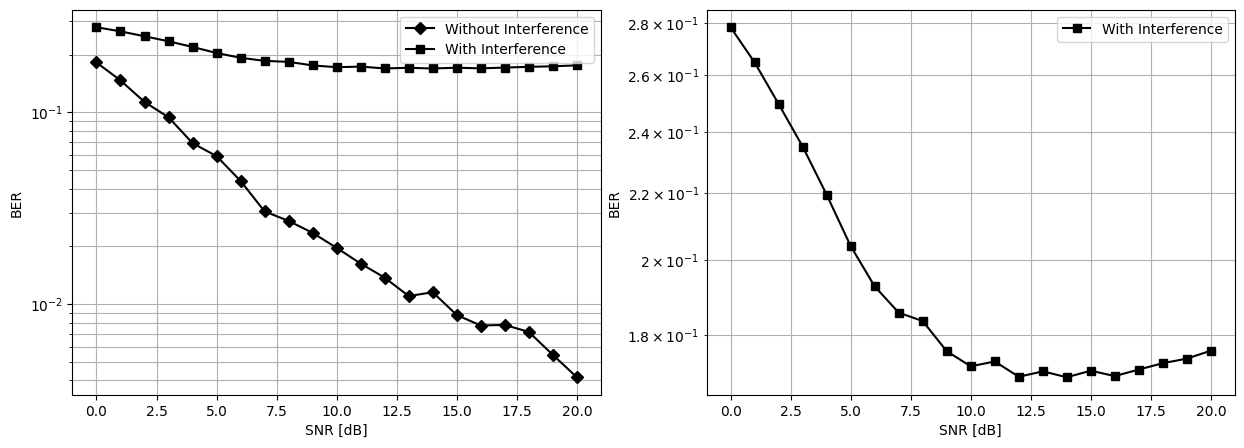

In [38]:
# Plot the results obtained from the simulation

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.semilogy(snr_db, BER_coded, "D-", label="Without Interference", color="black")
plt.semilogy(snr_db, BER_uncoded_interf, "s-", label="With Interference", color="black")
plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.xscale("linear")
plt.yscale("log")
plt.grid(which="both")
plt.legend()
plt.subplot(1, 2, 2)
plt.semilogy(snr_db, BER_uncoded_interf, "s-", label="With Interference", color="black")
plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.xscale("linear")
plt.yscale("log")
plt.grid(which="both")
plt.legend()
plt.show()

*We can now compare the results considereing interference with and without obstacles.* 

In [9]:
# Let's first impotr the pdf of the interferences with obstacles

# Load interferences
interference_ratio_obst = np.load("data/ratio_power_interf_obstacles.npy")

In [40]:
# Some parameters used to loop on the different SNR values and evaluate the BER.
ebn0 = np.arange(0, 21, 1) #dB
snr_db = ebn0 + 10*np.log10(tx_params["codingRate"]) + 10*np.log10(nmodbits) #dB
nb_seq =300
alpha = 0

# Initialization of the BER arrays to store the BER values for the different SNR values.
BER_coded_interf_obst = np.zeros(len(ebn0))
BER_uncoded_interf_obst = np.zeros(len(ebn0))

# Constrcution of the convolutional correcting code
gn = np.array([1, 1])
gd = np.array([1, 1, 1])
R1,R0,out_R1,out_R0 = poly2trellis(gn,gd)
d = 1
out_R1_tf = tf.convert_to_tensor(out_R1)
out_R0_tf = tf.convert_to_tensor(out_R0)
symb_R1 = mapper(out_R1_tf).numpy()
symb_R0 = mapper(out_R0_tf).numpy()

#Loop on the different SNR values
for ii in range(len(snr_db)) :

  # Initialization of the BER arrays to store the BER values for the different sequences.
  BER_coded_interf_ii_obst = np.zeros(nb_seq)
  BER_uncoded_interf_ii_obst = np.zeros(nb_seq)

  # Computation of the noise variance from the SNR value.
  var_noise = 1/(10**(0.1*snr_db[ii]))
  len_b = tx_params["kCode"]

  # Loop on the different sequences
  for jj in range(nb_seq) :

    # NOMA Power allocation
    Ptot_db = 10 # total power allocation in dB
    Ptot = 10**(0.1*Ptot_db)
    # Allocation of the power to the different users
    tx_params["powerAllocation"] =  get_power_allocation(tx_params, Ptot, var_noise)

    # Generation of the data to send
    data = np.zeros((tx_params["nUsers"], tx_params["nCode"])) # initialize the data to send
    b = binary_source([tx_params["nUsers"], tx_params["kCode"]]) # bits to send for each user
    b_array = b.numpy()

    # Encode the data to send for each user
    c_array = np.zeros((tx_params["nUsers"], 2*len(b_array[0])))
    for idx_user in range(tx_params["nUsers"]):
      (u_s,u_c) = conv_encoder(b_array[idx_user],R1,R0,out_R1,out_R0,len_b)
      c_array[idx_user] = np.reshape(np.transpose([u_s,u_c]),(2*len(u_s),))
    c = tf.convert_to_tensor(c_array)

    # Mapping the bits
    x = mapper(c)
    data = x.numpy()

    # Use of NOMA principle to separate the users in power
    data_out = NOMA(data, tx_params)
    
    # Channel, noise and interference 
    h = Rayleigh_canal(alpha, len(data_out))
    n = (1j*np.random.normal(scale=np.sqrt(var_noise/2), size=data_out.shape)+np.random.normal(scale=np.sqrt(var_noise/2),  size=data_out.shape))
    interference = 1/np.random.choice(interference_ratio_obst, size=h.shape) # Interference from other cell 
    # Random data of other cell
    possible_values = np.sqrt(2)*np.array([1+1j, -1-1j, 1-1j, -1+1j])
    data_other_cell = np.random.choice(possible_values, size=h.shape)
    # Effect of canal, noise and interference on the useful data
    y_canal = h*data_out+n+interference*data_other_cell

    # Reception 
    y_received = MyMMSE(data_out, h, var_noise, y_canal) # MMSE equalisation
    
    # Initialization of the arrays to store the decoded data
    y_decoded = np.zeros((tx_params["nUsers"], tx_params["kCode"]))
    y_demapped = np.zeros((tx_params["nUsers"], tx_params["nCode"])) # nCode noramlement (à changer après)

    # SIC 
    for idx_user in range(tx_params["nUsers"]):
      
      # Demapping
      y = demapper([tf.convert_to_tensor(y_received), var_noise])
      y_demapped[idx_user, :] = y.numpy()

      # Decoding
      y_user = viterbi_decoder(R1,R0,symb_R1, symb_R0,len_b, y_received)
      y_decoded[idx_user, :] = y_user

      # Re-encode the decoded data to retrieve the message of the next user
      (u_s,u_c) = conv_encoder(y_user,R1,R0,out_R1,out_R0,len_b)
      y_user_encoded = np.reshape(np.transpose([u_s,u_c]),(2*len(u_s),))
      y_user_encoded = tf.convert_to_tensor(y_user_encoded.reshape((1, len(y_user_encoded))))
      
      # Remove the decoded data from the received data
      y_received = y_received - mapper(y_user_encoded).numpy()[0]*np.sqrt(tx_params["powerAllocation"][idx_user])

    # Compute the BER for the different users
    y_demapped_tf = tf.convert_to_tensor(y_demapped)
    y_decoded_tf = tf.convert_to_tensor(y_decoded)
    c_hat = tf.cast(tf.less(0.0, y_demapped_tf), tf.double)
    b_hat = tf.cast(tf.less(0.0, y_decoded_tf), tf.float32)
    ber_uncoded = sionna.utils.metrics.compute_ber(c, c_hat)
    ber_coded = sionna.utils.metrics.compute_ber(b, b_hat)

    # Calculate the BER for the different users
    BER_coded_interf_ii_obst[jj] = ber_coded.numpy()
    BER_uncoded_interf_ii_obst[jj] = ber_uncoded.numpy()

  # Calculate the BER for the different SNR values
  BER_coded_interf_obst[ii] = np.mean(BER_coded_interf_ii_obst)
  BER_uncoded_interf_obst[ii] = np.mean(BER_uncoded_interf_ii_obst)

  print("Eb/N0 = " + str(ebn0[ii]) +  "dB, BER uncoded = " +  str(BER_uncoded_interf_obst[ii]))
  

Eb/N0 = 0dB, BER uncoded = 0.2723888888888889
Eb/N0 = 1dB, BER uncoded = 0.26082407407407404
Eb/N0 = 2dB, BER uncoded = 0.246037037037037
Eb/N0 = 3dB, BER uncoded = 0.2268055555555555
Eb/N0 = 4dB, BER uncoded = 0.21499074074074073
Eb/N0 = 5dB, BER uncoded = 0.20093518518518516
Eb/N0 = 6dB, BER uncoded = 0.18612962962962962
Eb/N0 = 7dB, BER uncoded = 0.18
Eb/N0 = 8dB, BER uncoded = 0.1768148148148148
Eb/N0 = 9dB, BER uncoded = 0.16628703703703704
Eb/N0 = 10dB, BER uncoded = 0.1655648148148148
Eb/N0 = 11dB, BER uncoded = 0.16277777777777777
Eb/N0 = 12dB, BER uncoded = 0.1641574074074074
Eb/N0 = 13dB, BER uncoded = 0.16256481481481483
Eb/N0 = 14dB, BER uncoded = 0.1630648148148148
Eb/N0 = 15dB, BER uncoded = 0.16427777777777777
Eb/N0 = 16dB, BER uncoded = 0.16635185185185183
Eb/N0 = 17dB, BER uncoded = 0.16187037037037036
Eb/N0 = 18dB, BER uncoded = 0.16252777777777777
Eb/N0 = 19dB, BER uncoded = 0.16603703703703704
Eb/N0 = 20dB, BER uncoded = 0.17071296296296296


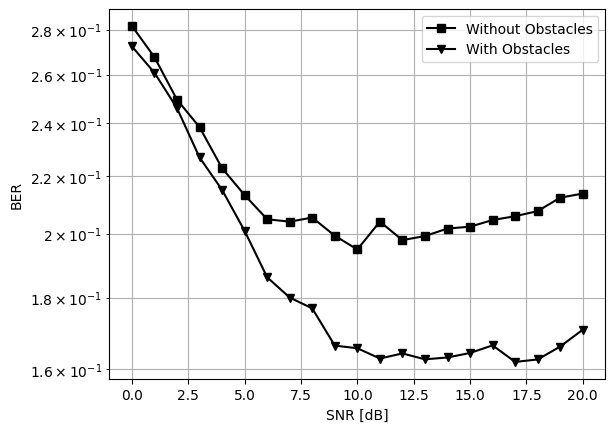

In [42]:
# Plot the results obtained from the simulation

plt.figure()
plt.semilogy(snr_db, BER_coded_interf, "s-", label="Without Obstacles", color="black")
plt.semilogy(snr_db, BER_uncoded_interf_obst, "v-", label="With Obstacles", color="black")
plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.xscale("linear")
plt.yscale("log")
plt.grid(which="both")
plt.legend()
plt.show()

*One could analyse the impact of th enumber of users in the cell on the BER-SNR curve. Let's investigate that.*

In [10]:
# Initiate number of users and equivalent BERs to store the data
n_users = np.array([1, 2, 4, 8])
BER_n_users = np.zeros((len(n_users), len(ebn0)))

# Some parameters used to loop on the different SNR values and evaluate the BER.
ebn0 = np.arange(0, 21, 1) #dB
snr_db = ebn0 + 10*np.log10(tx_params["codingRate"]) + 10*np.log10(nmodbits) #dB
nb_seq =300
alpha = 0

for u in range(len(n_users)) : 

    tx_params = {
    "nUsers" : n_users[u],                      # The number of users. 
    "powerAllocation" : np.zeros(n_users[u]),   # Initialisation of an array representing the power allocation for each user. 
    "nCode" : 120,                     # The number of bits representing the message to send after coding. 
    "kCode" : 60,                      # The number of bits representing the message to send.
    "codingRate": 1/2,                 # The coding rate of the error correcting code.  
    }

    # Initialization of the BER arrays to store the BER values for the different SNR values.
    BER_coded_interf_obst = np.zeros(len(ebn0))
    BER_uncoded_interf_obst = np.zeros(len(ebn0))

    # Constrcution of the convolutional correcting code
    gn = np.array([1, 1])
    gd = np.array([1, 1, 1])
    R1,R0,out_R1,out_R0 = poly2trellis(gn,gd)
    d = 1
    out_R1_tf = tf.convert_to_tensor(out_R1)
    out_R0_tf = tf.convert_to_tensor(out_R0)
    symb_R1 = mapper(out_R1_tf).numpy()
    symb_R0 = mapper(out_R0_tf).numpy()

    #Loop on the different SNR values
    for ii in range(len(snr_db)) :

        # Initialization of the BER arrays to store the BER values for the different sequences.
        BER_coded_interf_ii_obst = np.zeros(nb_seq)
        BER_uncoded_interf_ii_obst = np.zeros(nb_seq)

        # Computation of the noise variance from the SNR value.
        var_noise = 1/(10**(0.1*snr_db[ii]))
        len_b = tx_params["kCode"]

        # Loop on the different sequences
        for jj in range(nb_seq) :

            # NOMA Power allocation
            Ptot_db = 10 # total power allocation in dB
            Ptot = 10**(0.1*Ptot_db)
            # Allocation of the power to the different users
            tx_params["powerAllocation"] =  get_power_allocation(tx_params, Ptot, var_noise)

            # Generation of the data to send
            data = np.zeros((tx_params["nUsers"], tx_params["nCode"])) # initialize the data to send
            b = binary_source([tx_params["nUsers"], tx_params["kCode"]]) # bits to send for each user
            b_array = b.numpy()

            # Encode the data to send for each user
            c_array = np.zeros((tx_params["nUsers"], 2*len(b_array[0])))
            for idx_user in range(tx_params["nUsers"]):
                (u_s,u_c) = conv_encoder(b_array[idx_user],R1,R0,out_R1,out_R0,len_b)
                c_array[idx_user] = np.reshape(np.transpose([u_s,u_c]),(2*len(u_s),))
            c = tf.convert_to_tensor(c_array)

            # Mapping the bits
            x = mapper(c)
            data = x.numpy()

            # Use of NOMA principle to separate the users in power
            data_out = NOMA(data, tx_params)
            
            # Channel, noise and interference 
            h = Rayleigh_canal(alpha, len(data_out))
            n = (1j*np.random.normal(scale=np.sqrt(var_noise/2), size=data_out.shape)+np.random.normal(scale=np.sqrt(var_noise/2),  size=data_out.shape))
            interference = 1/np.random.choice(interference_ratio_obst, size=h.shape) # Interference from other cell 
            # Random data of other cell
            possible_values = np.sqrt(2)*np.array([1+1j, -1-1j, 1-1j, -1+1j])
            data_other_cell = np.random.choice(possible_values, size=h.shape)
            # Effect of canal, noise and interference on the useful data
            y_canal = h*data_out+n+interference*data_other_cell

            # Reception 
            y_received = MyMMSE(data_out, h, var_noise, y_canal) # MMSE equalisation
            
            # Initialization of the arrays to store the decoded data
            y_decoded = np.zeros((tx_params["nUsers"], tx_params["kCode"]))
            y_demapped = np.zeros((tx_params["nUsers"], tx_params["nCode"])) # nCode noramlement (à changer après)

            # SIC 
            for idx_user in range(tx_params["nUsers"]):
            
                # Demapping
                y = demapper([tf.convert_to_tensor(y_received), var_noise])
                y_demapped[idx_user, :] = y.numpy()

                # Decoding
                y_user = viterbi_decoder(R1,R0,symb_R1, symb_R0,len_b, y_received)
                y_decoded[idx_user, :] = y_user

                # Re-encode the decoded data to retrieve the message of the next user
                (u_s,u_c) = conv_encoder(y_user,R1,R0,out_R1,out_R0,len_b)
                y_user_encoded = np.reshape(np.transpose([u_s,u_c]),(2*len(u_s),))
                y_user_encoded = tf.convert_to_tensor(y_user_encoded.reshape((1, len(y_user_encoded))))
                
                # Remove the decoded data from the received data
                y_received = y_received - mapper(y_user_encoded).numpy()[0]*np.sqrt(tx_params["powerAllocation"][idx_user])

                # Compute the BER for the different users
                y_demapped_tf = tf.convert_to_tensor(y_demapped)
                y_decoded_tf = tf.convert_to_tensor(y_decoded)
                c_hat = tf.cast(tf.less(0.0, y_demapped_tf), tf.double)
                b_hat = tf.cast(tf.less(0.0, y_decoded_tf), tf.float32)
                ber_uncoded = sionna.utils.metrics.compute_ber(c, c_hat)
                ber_coded = sionna.utils.metrics.compute_ber(b, b_hat)

                # Calculate the BER for the different users
                BER_coded_interf_ii_obst[jj] = ber_coded.numpy()
                BER_uncoded_interf_ii_obst[jj] = ber_uncoded.numpy()

        # Calculate the BER for the different SNR values
        BER_n_users[u, ii] = np.mean(BER_uncoded_interf_ii_obst)


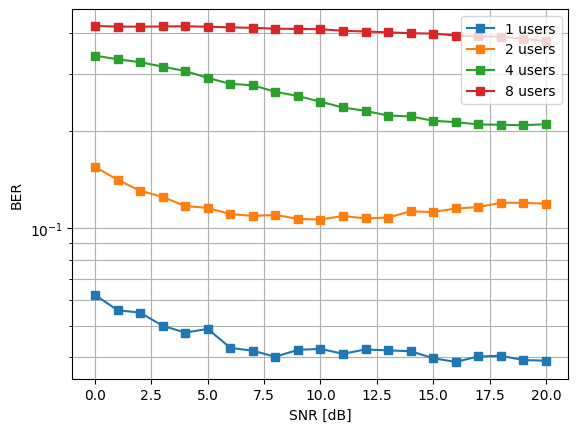

In [11]:
plt.figure()
for i in range(len(n_users)):
    plt.semilogy(snr_db, BER_n_users[i], "s-", label=str(n_users[i])+ " users")
plt.xlabel("SNR [dB]")
plt.ylabel("BER")
plt.xscale("linear")
plt.yscale("log")
plt.grid(which="both")
plt.legend()
plt.show()

*Another metric to investigate is the spectral efficiency of the NOMA method. To do so, as done before, we will iterate on a lot of communications and compute the mean of the capacity for a large number of SNR values.*

In [17]:
# Let's go back to the baseline code simulation

tx_params = {
    "nUsers" : 3,                      # The number of users. 
    "powerAllocation" : np.zeros(3),   # Initialisation of an array representing the power allocation for each user. 
    "nCode" : 120,                     # The number of bits representing the message to send after coding. 
    "kCode" : 60,                      # The number of bits representing the message to send.
    "codingRate": 1/2,                 # The coding rate of the error correcting code.  
    }

In [31]:
# Spectral efficiency of the system

# Some parameters used to loop on the different SNR values and evaluate the BER.
ebn0 = np.arange(0, 21, 1) #dB
snr_db = ebn0 + 10*np.log10(tx_params["codingRate"]) + 10*np.log10(nmodbits) #dB
nb_seq =1000
alpha = 0

# Initialization of the BER arrays to store the BER values for the different SNR values.
spectral_efficiency= np.zeros(len(ebn0))

#Loop on the different SNR values
for ii in range(len(snr_db)) :

  # Initialization of the BER arrays to store the BER values for the different sequences.
  spectral_efficiency_ii = np.zeros(nb_seq)

  # Computation of the noise variance from the SNR value.
  var_noise = 1/(10**(0.1*snr_db[ii]))
  len_b = tx_params["kCode"]

  # Loop on the different sequences
  for jj in range(nb_seq) :

    # NOMA Power allocation
    Ptot_db = 10 # total power allocation in dB
    Ptot = 10**(0.1*Ptot_db)
    # Allocation of the power to the different users
    tx_params["powerAllocation"] =  get_power_allocation(tx_params, Ptot, var_noise)
    
    # Channel, noise and interference 
    h = Rayleigh_canal(alpha, len(data_out))
    n = (1j*np.random.normal(scale=np.sqrt(var_noise/2), size=data_out.shape)+np.random.normal(scale=np.sqrt(var_noise/2),  size=data_out.shape))
    interference = 1/np.random.choice(interference_ratio_obst, size=h.shape) # Interference from other cell 
    
    # Calculate the spectral efficiency of the users
    for u in range(tx_params["nUsers"]): 
      spectral_efficiency_ii[jj] += np.log2(1+tx_params["powerAllocation"][u]*np.mean(np.abs(h)**2)/(np.mean(np.abs(n)**2)+ np.mean(interference*Ptot) ))

  # Calculate the mean spectral efficiency for this SNR value
  spectral_efficiency[ii] = np.mean(spectral_efficiency_ii)

  print("Eb/N0 = " + str(ebn0[ii]) +  "dB, Spectral efficiency = " +  str(spectral_efficiency[ii]))
  

Eb/N0 = 0dB, Spectral efficiency = 3.1087090952338787
Eb/N0 = 1dB, Spectral efficiency = 3.1213239717833705
Eb/N0 = 2dB, Spectral efficiency = 3.1686131628622842
Eb/N0 = 3dB, Spectral efficiency = 3.188268951118859
Eb/N0 = 4dB, Spectral efficiency = 3.168119979694754
Eb/N0 = 5dB, Spectral efficiency = 3.1787653308821793
Eb/N0 = 6dB, Spectral efficiency = 3.12152901350591
Eb/N0 = 7dB, Spectral efficiency = 3.1260521643936396
Eb/N0 = 8dB, Spectral efficiency = 3.1216434845371923
Eb/N0 = 9dB, Spectral efficiency = 3.0838377861844957
Eb/N0 = 10dB, Spectral efficiency = 3.0560511308744025
Eb/N0 = 11dB, Spectral efficiency = 3.0146274394093857
Eb/N0 = 12dB, Spectral efficiency = 2.988138561162019
Eb/N0 = 13dB, Spectral efficiency = 2.9585574403318535
Eb/N0 = 14dB, Spectral efficiency = 2.935601763201736
Eb/N0 = 15dB, Spectral efficiency = 2.881934206227463
Eb/N0 = 16dB, Spectral efficiency = 2.8700639688678344
Eb/N0 = 17dB, Spectral efficiency = 2.8533777572711703
Eb/N0 = 18dB, Spectral effi

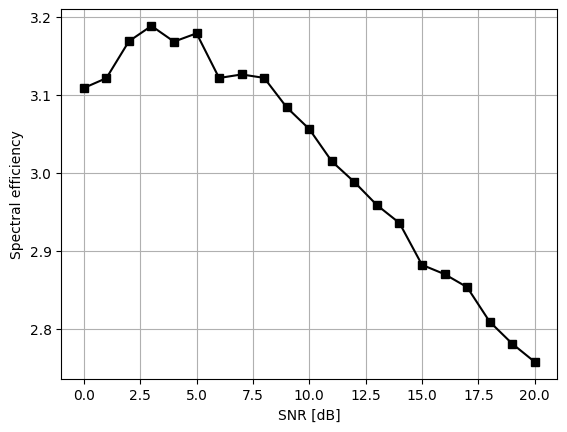

In [32]:
# Plot the results for the spectral efficiency distribution

plt.figure()
plt.plot(snr_db, spectral_efficiency, "s-", color="black")
plt.xlabel("SNR [dB]")
plt.ylabel("Spectral efficiency")
plt.xscale("linear")
plt.yscale("linear")
plt.grid(which="both")
plt.show()


*We can now alanyse the effect of the number of users on the spectral efficiency.*

In [ ]:
# Spectral efficiency of the system - Impact of the number of users in the system

# Initiate number of users and equivalent BERs to store the data
n_users = np.array([1, 2, 4, 8])
BER_n_users = np.zeros((len(n_users), len(ebn0)))

# Some parameters used to loop on the different SNR values and evaluate the BER.
ebn0 = np.arange(0, 21, 1) #dB
snr_db = ebn0 + 10*np.log10(tx_params["codingRate"]) + 10*np.log10(nmodbits) #dB
nb_seq =1000
alpha = 0

# Initialization of the BER arrays to store the BER values for the different SNR values.
spectral_efficiency_users = np.zeros((len(n_users), len(ebn0)))

# Loop over the different number of users
for u in range(len(n_users)) :

  tx_params = {
    "nUsers" : n_users[u],                      # The number of users.
    "powerAllocation" : np.zeros(n_users[u]),   # Initialisation of an array representing the power allocation for each user.
    "nCode" : 120,                     # The number of bits representing the message to send after coding.
    "kCode" : 60,                      # The number of bits representing the message to send.
    "codingRate": 1/2,                 # The coding rate of the error correcting code.
    }

  #Loop on the different SNR values
  for ii in range(len(snr_db)) :

    # Initialization of the BER arrays to store the BER values for the different sequences.
    spectral_efficiency_ii = np.zeros(nb_seq)

    # Computation of the noise variance from the SNR value.
    var_noise = 1/(10**(0.1*snr_db[ii]))
    len_b = tx_params["kCode"]

    # Loop on the different sequences
    for jj in range(nb_seq) :

      # NOMA Power allocation
      Ptot_db = 10 # total power allocation in dB
      Ptot = 10**(0.1*Ptot_db)
      # Allocation of the power to the different users
      tx_params["powerAllocation"] =  get_power_allocation(tx_params, Ptot, var_noise)
      
      # Channel, noise and interference 
      h = Rayleigh_canal(alpha, len(data_out))
      n = (1j*np.random.normal(scale=np.sqrt(var_noise/2), size=data_out.shape)+np.random.normal(scale=np.sqrt(var_noise/2),  size=data_out.shape))
      interference = 1/np.random.choice(interference_ratio_obst, size=h.shape) # Interference from other cell 
      
      # Calculate the spectral efficiency of the users
      for u in range(tx_params["nUsers"]): 
        spectral_efficiency_ii[jj] += np.log2(1+tx_params["powerAllocation"][u]*np.mean(np.abs(h)**2)/(np.mean(np.abs(n)**2)+ np.mean(interference*Ptot) ))

    # Calculate the mean spectral efficiency for this SNR value
    spectral_efficiency[u, ii] = np.mean(spectral_efficiency_ii)

  print("Eb/N0 = " + str(ebn0[ii]) +  "dB, Spectral efficiency = " +  str(spectral_efficiency[ii]))
  